In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import xgboost as xgb 
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import *

In [2]:
df = pd.read_csv('modified_data.csv')
del df['Unnamed: 0']

In [3]:
choose_factor = [i for i in df.columns if i in ['rounds','percent_total','valuation','value_chg',
                                                 'follow_count','industry_2','industry_val',
                                                 'investor_count','founder_count','male_ratio','rate']]

In [4]:
choose_feature = df[choose_factor]

In [5]:
choose_feature['investor_count'] = choose_feature['investor_count'].fillna(choose_feature['investor_count'].mean())
choose_feature['founder_count'] = choose_feature['founder_count'].fillna(choose_feature['founder_count'].mean())

In [6]:
choose_feature.to_csv(r'choose_feature.csv')

In [7]:
# fea = choose_feature.copy()

In [8]:
choose_label = df['label']

## Split training set and test set

In [9]:
# X_train, X_test, y_train, y_test = train_test_split(choose_feature, choose_label, test_size=0.2)

In [10]:
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test)

In [11]:
from sklearn.model_selection import train_test_split  # Split training set and test set
from sklearn.preprocessing import LabelEncoder   # Labelled classification parameters
le = LabelEncoder()
choose_label = le.fit_transform(choose_label)
X_train,X_test,y_train,y_test = train_test_split(choose_feature, choose_label,test_size=0.3,random_state=1,stratify=choose_label)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)
# 1.Booster parameters
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    
    'num_class': 10,               # Number of classes, used in conjunction with multisoftmax    
                                   #'objective': 'multi:softmax'
                                   # Multiple classification issues 'objective':'binary:logistic'
    'gamma': 0.1,                  # The larger the parameter, the more conservative it is, usually 0.1 or 0.2.
    'max_depth': 30,               # Build the depth of the tree, the larger the tree, the easier it is to over-fit.
    'lambda': 1,                   # The parameter of the L1 regularisation term that controls the weight value of the model complexity.
                                   #the larger the parameter, the less likely the model is to be overfitted.
    'subsample': 0.9,              # randomly sampled training samples
    'colsample_bytree': 0.8,       # column sampling during tree generation
    'min_child_weight': 3,
    'silent': 0,                   # If it is set to 1, no run message is output and it is better to set it to 0.
    'eta': 0.003,                  # similar with the learning rate
    'seed': 1000,
    'nthread': 6,                  # cpu threads# specify the validation set
    'eval_metric':'auc'
}
plst = list(params.items())
# evallist = [(dtest, 'eval'), (dtrain, 'train')]   # specify the validation set

In [12]:
# 2.train
num_round = 10
bst = xgb.train(plst, dtrain, num_round)
#bst = xgb.train( plst, dtrain, num_round, evallist )

[00:44:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [13]:
ypred = bst.predict(dtest)

In [14]:
xgboost_precison = pd.DataFrame(ypred,y_test).reset_index()
xgboost_precison.columns = ['predict','test']
xgboost_precison = xgboost_precison.astype(int)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

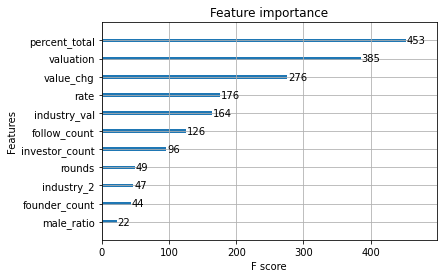

In [15]:
# 1.feature importance
xgb.plot_importance(bst)

In [16]:
# valuation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
accuracy = accuracy_score(y_test,ypred)
precision = precision_score(y_test,ypred)
print("accuarcy: %.3f%%" % (accuracy*100.0))
print("precision: %.3f%%" % (precision*100.0))

accuarcy: 78.927%
precision: 82.366%


In [17]:
# plt.rcParams['font.sans-serif']=['SimHei']
# plt.rcParams['axes.unicode_minus'] = False

In [18]:
import seaborn as sns
def dataPlot():
    # Plotting based on the results of the correlation coefficient calculation
    
    fig,ax=plt.subplots(figsize=(18,8))
#     key_list=['A','B','C','D','E','F','G','H']
    sns.heatmap(pd.DataFrame(np.round(X_train[choose_factor].corr(),4),columns=choose_factor,index=choose_factor),annot=True,vmax=1,vmin=0,xticklabels=True,
                             yticklabels=True,square=True,cmap="YlGnBu")
    ax.set_title(' Feature Correlation Coefficients ', fontsize=18)
    ax.set_ylabel('Y', fontsize=16)
    ax.set_xlabel('X', fontsize=16)

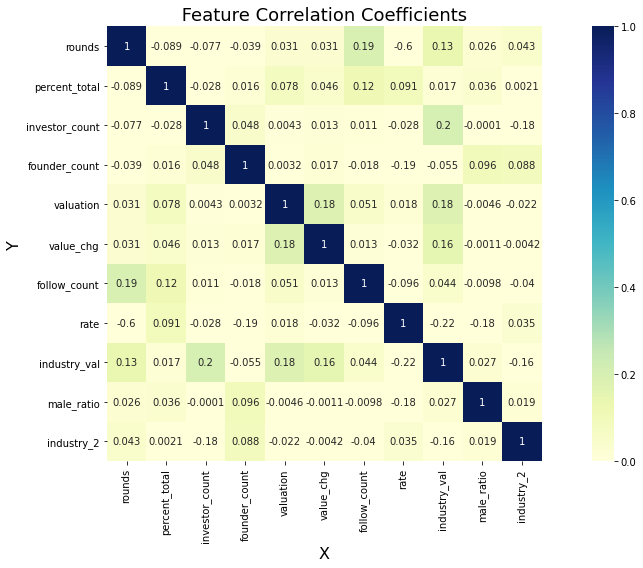

In [19]:
dataPlot()

## Random Forest

In [20]:
# from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [21]:
choose_feature['value_chg'] = choose_feature['value_chg'].fillna(choose_feature['value_chg'].mean())

In [22]:
choose_feature['valuation'] = choose_feature['valuation'].fillna(choose_feature['valuation'].mean())

In [26]:
choose_feature['industry_val'] = choose_feature['industry_val'].fillna(choose_feature['valuation'].mean())

In [35]:
print(np.isinf(choose_feature).any())

rounds            False
percent_total     False
investor_count    False
founder_count     False
valuation         False
value_chg         False
follow_count      False
rate              False
industry_val      False
male_ratio        False
industry_2        False
dtype: bool


In [36]:
X_train,X_test,y_train,y_test = train_test_split(choose_feature, choose_label,test_size=0.3,random_state=1,stratify=choose_label)

In [37]:
clf_forest = RandomForestClassifier(n_estimators=10, max_features='sqrt', max_depth=100, class_weight='balanced')
clf_forest.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=100,
                       max_features='sqrt', n_estimators=10)

In [38]:
X_test.shape

(2534, 11)

In [39]:
predict = clf_forest.predict(X_test)

In [40]:
from sklearn.metrics import precision_score
import sklearn.metrics as sm
# sm.confusion_matrix(y_test,predict)
print(sm.classification_report(y_test,predict))

precision = precision_score(y_test,predict)
print("precision: %.3f%%" % (precision*100.0))

              precision    recall  f1-score   support

           0       0.68      0.71      0.70       873
           1       0.85      0.82      0.83      1661

    accuracy                           0.79      2534
   macro avg       0.76      0.77      0.77      2534
weighted avg       0.79      0.79      0.79      2534

precision: 84.592%


## the feature importance

In [41]:
# print the importance of features
importances = clf_forest.feature_importances_ 
importances_df = pd.DataFrame([choose_factor, importances], index=['Features', 'Importances']).T
importances_df.sort_values(by='Importances',ascending=False).head(10)

,Features,Importances
1,percent_total,0.402718
0,rounds,0.129109
5,value_chg,0.110272
4,valuation,0.097341
6,follow_count,0.075553
7,rate,0.075455
8,industry_val,0.039031
10,industry_2,0.026816
2,investor_count,0.017878
3,founder_count,0.01383


<AxesSubplot:title={'center':'Feature Importance'}, xlabel='Features'>

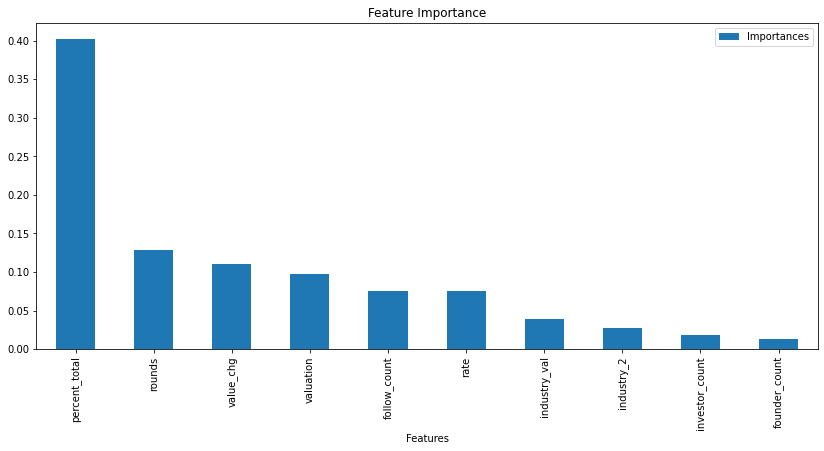

In [42]:
importances_df.set_index('Features').sort_values(by='Importances',ascending=False).head(10).plot.bar(figsize=(14,6),title='Feature Importance')

In [43]:
# Define the process of scoring the model and forming the confusion_matrix as a function
def model_evaluation(estimator, train_data, real_mark):
    # predict
    predict = estimator.predict(train_data)
    # calculate the model score
    compare_df = pd.DataFrame({'Real': real_mark, 'Predict': predict})
    compare_df['mark'] = ~np.logical_xor(compare_df.Predict, compare_df.Real)
    score = estimator.score(train_data, real_mark)
    print(f'Accuracy: {score}\n\nConfusion matrix:\n')
    # calculate confusion matrix
    confusion = confusion_matrix(real_mark, predict, labels=[0,1])
    confusion_df = pd.DataFrame(confusion, index=['0_real', '1_real'], columns=['0_predict', '1_predict'] )
    return confusion_df

In [44]:
# In-sample prediction results
model_evaluation(clf_forest, X_test, y_test)

Accuracy: 0.7857142857142857

Confusion matrix:



,0_predict,1_predict
0_real,624,249
1_real,294,1367


## Naive Bayes

In [45]:
from sklearn.naive_bayes import BernoulliNB

In [46]:
# Training the model, the data passed in for machine learning needs to be in the np.array data structure.
clf = BernoulliNB()
clf.fit(X_train,y_train)

BernoulliNB()

In [47]:
predict = clf.predict(X_test)

In [48]:
from sklearn.metrics import precision_score
import sklearn.metrics as sm
# sm.confusion_matrix(y_test,predict)
print(sm.classification_report(y_test,predict))

precision = precision_score(y_test,predict)
print("precision: %.3f%%" % (precision*100.0))

              precision    recall  f1-score   support

           0       0.55      0.08      0.15       873
           1       0.67      0.96      0.79      1661

    accuracy                           0.66      2534
   macro avg       0.61      0.52      0.47      2534
weighted avg       0.63      0.66      0.57      2534

precision: 66.708%


In [49]:
# In-sample prediction results
model_evaluation(clf, X_test, y_test)

Accuracy: 0.6610102604577742

Confusion matrix:



,0_predict,1_predict
0_real,74,799
1_real,60,1601


# KFold

In [51]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = KFold(n_splits=4 ,random_state=4000,shuffle=True)

In [52]:
choose_feature['label'] = choose_label
# X = choose_feature.copy()
X = choose_feature[choose_factor].values
y = choose_label

In [53]:
from sklearn.metrics import accuracy_score
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    le = LabelEncoder()
    choose_label = le.fit_transform(choose_label)
#     X_train,X_test,y_train,y_test = train_test_split(choose_feature, choose_label,test_size=0.3,random_state=1,stratify=choose_label)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
   
    # 1.Booster parameters
    params = {
        'booster': 'gbtree',
        'objective': 'multi:softmax',

        'num_class': 10,               # Number of classes, used in conjunction with multisoftmax    
                                       #'objective': 'multi:softmax'
                                       # Multiple classification issues 'objective':'binary:logistic'
        'gamma': 0.1,                  # The larger the parameter, the more conservative it is, usually 0.1 or 0.2.
        'max_depth': 30,               # Build the depth of the tree, the larger the tree, the easier it is to over-fit.
        'lambda': 1,                   # The parameter of the L1 regularisation term that controls the weight value of the model complexity.
                                       #the larger the parameter, the less likely the model is to be overfitted.
        'subsample': 0.9,              # randomly sampled training samples
        'colsample_bytree': 0.8,       # column sampling during tree generation
        'min_child_weight': 3,
        'silent': 0,                   # If it is set to 1, no run message is output and it is better to set it to 0.
        'eta': 0.003,                  # similar with the learning rate
        'seed': 1000,
        'nthread': 6,                  # cpu threads# specify the validation set
        'eval_metric':'auc'
    }
    plst = list(params.items())
    # evallist = [(dtest, 'eval'), (dtrain, 'train')]   # specify the validation set

    # 2.train
    num_round = 10
    bst = xgb.train(plst, dtrain, num_round)
    #bst = xgb.train( plst, dtrain, num_round, evallist )

    ypred = bst.predict(dtest)

    xgboost_precison = pd.DataFrame(ypred,y_test).reset_index()
    xgboost_precison.columns = ['predict','test']
    xgboost_precison = xgboost_precison.astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(y_test,ypred)
    print("accuarcy: %.3f%%" % (accuracy*100.0))


TRAIN: [   1    2    4 ... 8440 8441 8442] TEST: [   0    3    6 ... 8439 8443 8444]
[00:52:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


accuarcy: 79.451%
TRAIN: [   0    1    3 ... 8440 8443 8444] TEST: [   2    4    8 ... 8432 8441 8442]
[00:52:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


accuarcy: 79.441%
TRAIN: [   0    2    3